In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp

from Qatmosphere_2d import AtmosphereMaps

import yaml

import qubic
from qubic.lib.Instrument.Qacquisition import QubicAcquisition
from qubic.lib.Instrument.Qinstrument import QubicInstrument
from qubic.lib.Qscene import QubicScene
from qubic.lib.Qsamplings import get_pointing

from qubic.scripts.MapMaking.src.FMM.model.planck_timeline import InputMaps

from qubic.lib.MapMaking.Qcg import PCGAlgorithm
from pyoperators.iterative.core import AbnormalStopIteration

from pyoperators import MPI, BlockColumnOperator, BlockDiagonalOperator, DiagonalOperator, ReshapeOperator

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

%matplotlib inline

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
# Import simulation parameters
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 

In [3]:
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)
qubic_dict = atm.qubic_dict

(786432, 3)


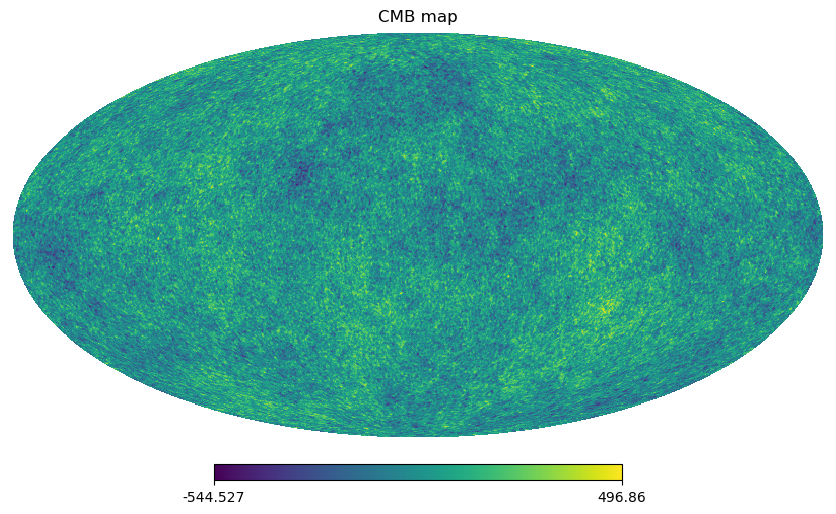

In [4]:
cmb_maps = InputMaps({'cmb':42}, [150e9], 1, params['nside']).m_nu[0]
print(cmb_maps.shape)
hp.mollview(cmb_maps[:, 0], title='CMB map')

786432


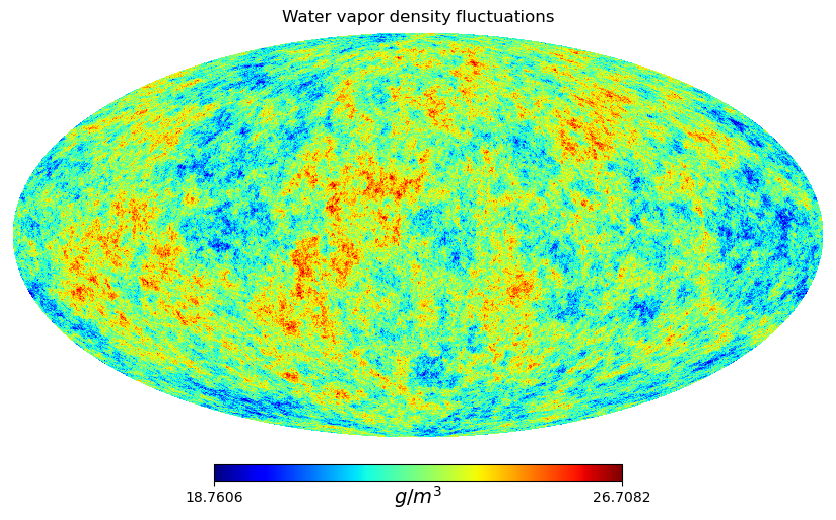

In [5]:
wv_fluctuations = atm.rho_map
print(wv_fluctuations.shape[0])
hp.mollview(wv_fluctuations, cmap='jet', title='Water vapor density fluctuations', unit=r'$g/m^{3}$')

In [6]:
atm.frequencies

array([132.92014967, 136.30295415, 139.77185066, 143.32903024,
       146.97673968, 150.71728296, 154.5530227 , 158.48638163,
       162.51984414, 166.65595787, 194.94955285, 199.91099941,
       204.9987143 , 210.21591101, 215.56588487, 221.05201501,
       226.67776663, 232.44669305, 238.36243807, 244.42873822])

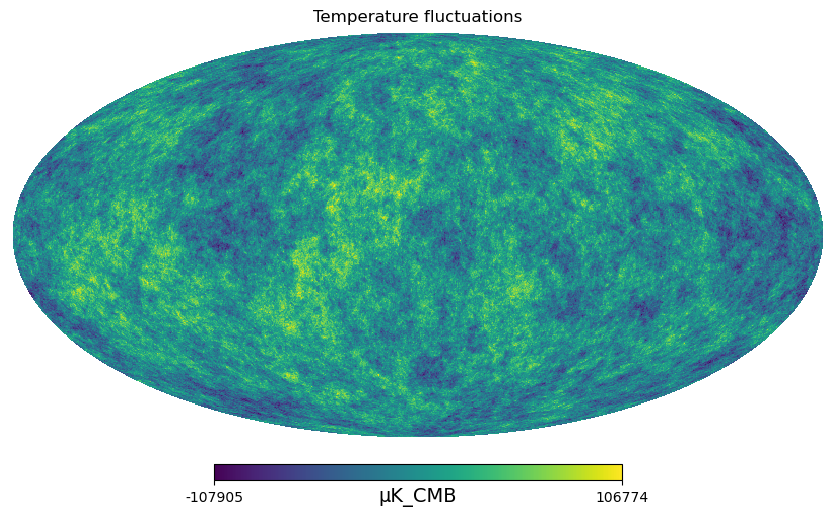

In [7]:
temp_fluctuations = np.zeros((wv_fluctuations.shape[0], 3))
temp_fluctuations[:, 0] = atm.get_temp_maps(wv_fluctuations)[0]
temp_fluctuations[:, 0] -= np.mean(temp_fluctuations[:, 0])

hp.mollview(temp_fluctuations[:, 0], title='Temperature fluctuations', unit='µK_CMB')

In [8]:
q_instrument = QubicInstrument(qubic_dict)
q_sampling = get_pointing(qubic_dict)
q_scene = QubicScene(qubic_dict)

q_acquisition = QubicAcquisition(q_instrument, q_sampling, q_scene, qubic_dict)

You asked 2000 pointings with repeat strategy so I will provide 666 pointings repeated 3 times.


In [9]:
coverage = q_acquisition.get_coverage()

covnorm = coverage / coverage.max()
seenpix = covnorm > params['coverage_cut']

center = np.array([0, -57])
qubic_patch = qubic.lib.Qsamplings.equ2gal(center[0], center[1])

Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.


In [10]:
H_qubic = q_acquisition.get_operator()
R_qubic = ReshapeOperator(H_qubic.shapeout, H_qubic.shape[0])
invN_qubic = R_qubic(q_acquisition.get_invntt_operator(False, False)(R_qubic.T))
d_qubic = H_qubic(temp_fluctuations).ravel()

Info apcnb2325: Allocating (1982016,9) elements = 272.1884765625 MiB in FSRRotation3dMatrix.__init__.


In [11]:
print(temp_fluctuations.shape)
print(cmb_maps.shape)

(786432, 3)
(786432, 3)


In [12]:
H_planck = ReshapeOperator(temp_fluctuations.shape, temp_fluctuations.ravel().shape)
invN_planck = DiagonalOperator(np.ones(H_planck.shapeout))
d_planck = H_planck(temp_fluctuations)

In [13]:
if params['external_data']:
    H = BlockColumnOperator([R_qubic(H_qubic), H_planck], axisout=0)
    invN = BlockDiagonalOperator([invN_qubic, invN_planck], axisout=0)
    d = np.concatenate((d_qubic, d_planck))
else:
    H = R_qubic(H_qubic)
    invN = invN_qubic
    d = d_qubic

In [14]:
A = H.T * invN * H
b = H.T * invN * d.flatten()
x0 = temp_fluctuations*0
true_maps = temp_fluctuations #+ cmb_maps

In [15]:
vec = np.ones(H.shapein)

conditioner = H.T * invN_qubic * H(vec)
M = DiagonalOperator(conditioner)

In [16]:
# Run PCG
algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-10,
    maxiter=2000,
    disp=True,
    M=None,
    center=[0, -57],
    reso=15,
    seenpix=seenpix,
    input=true_maps,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

2
 Iter     Tol      time
   1: 5.0272e-01 0.19195 [12716.0857216    907.6759538  23302.73808729 ...  4317.99009711
  7323.65816909  2823.03459809]
2
   2: 2.4504e-01 0.16588 [12048.96756297  1255.03484407 21835.01332498 ...  3742.68517152
  7434.26143656  2337.43608983]
2
   3: 1.4337e-01 0.17108 [ 9409.0273354    585.13301612 20266.28391004 ...  3650.66385054
  6631.06770611  2163.52935907]
2
   4: 1.0567e-01 0.15733 [ 6757.74331685   104.06622099 18129.41747717 ...  3703.85367596
  5579.02064562  1888.94500707]
2
   5: 8.3723e-02 0.16505 [ 3948.68796835   859.6578014  15605.7480739  ...  3943.0160281
  4209.61912964  1709.02812994]
2
   6: 6.7282e-02 0.15988 [ 1281.38733908  1601.92169778 13107.07066514 ...  4344.10841785
  2636.31433036  1757.77058199]
2
   7: 5.6702e-02 0.18567 [  861.54727717  2193.86014722 10921.4410142  ...  4592.41622354
  1305.03286789  1900.14279211]
2
   8: 5.0708e-02 0.17223 [2873.86199679 2785.77564153 8803.14737894 ... 4744.67261775   41.03989621
 2126.0

Text(0, 0.5, 'Convergence')

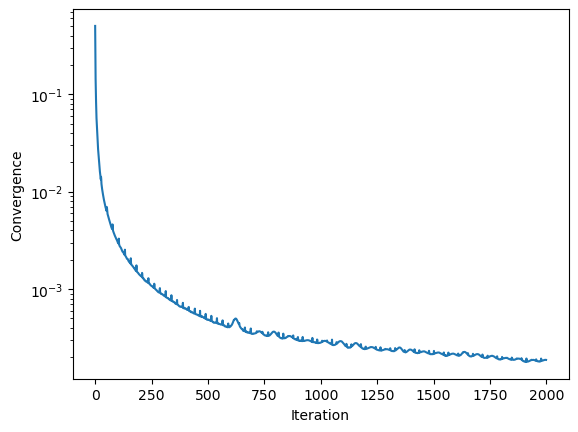

In [17]:
plt.plot(output['convergence'])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Convergence')

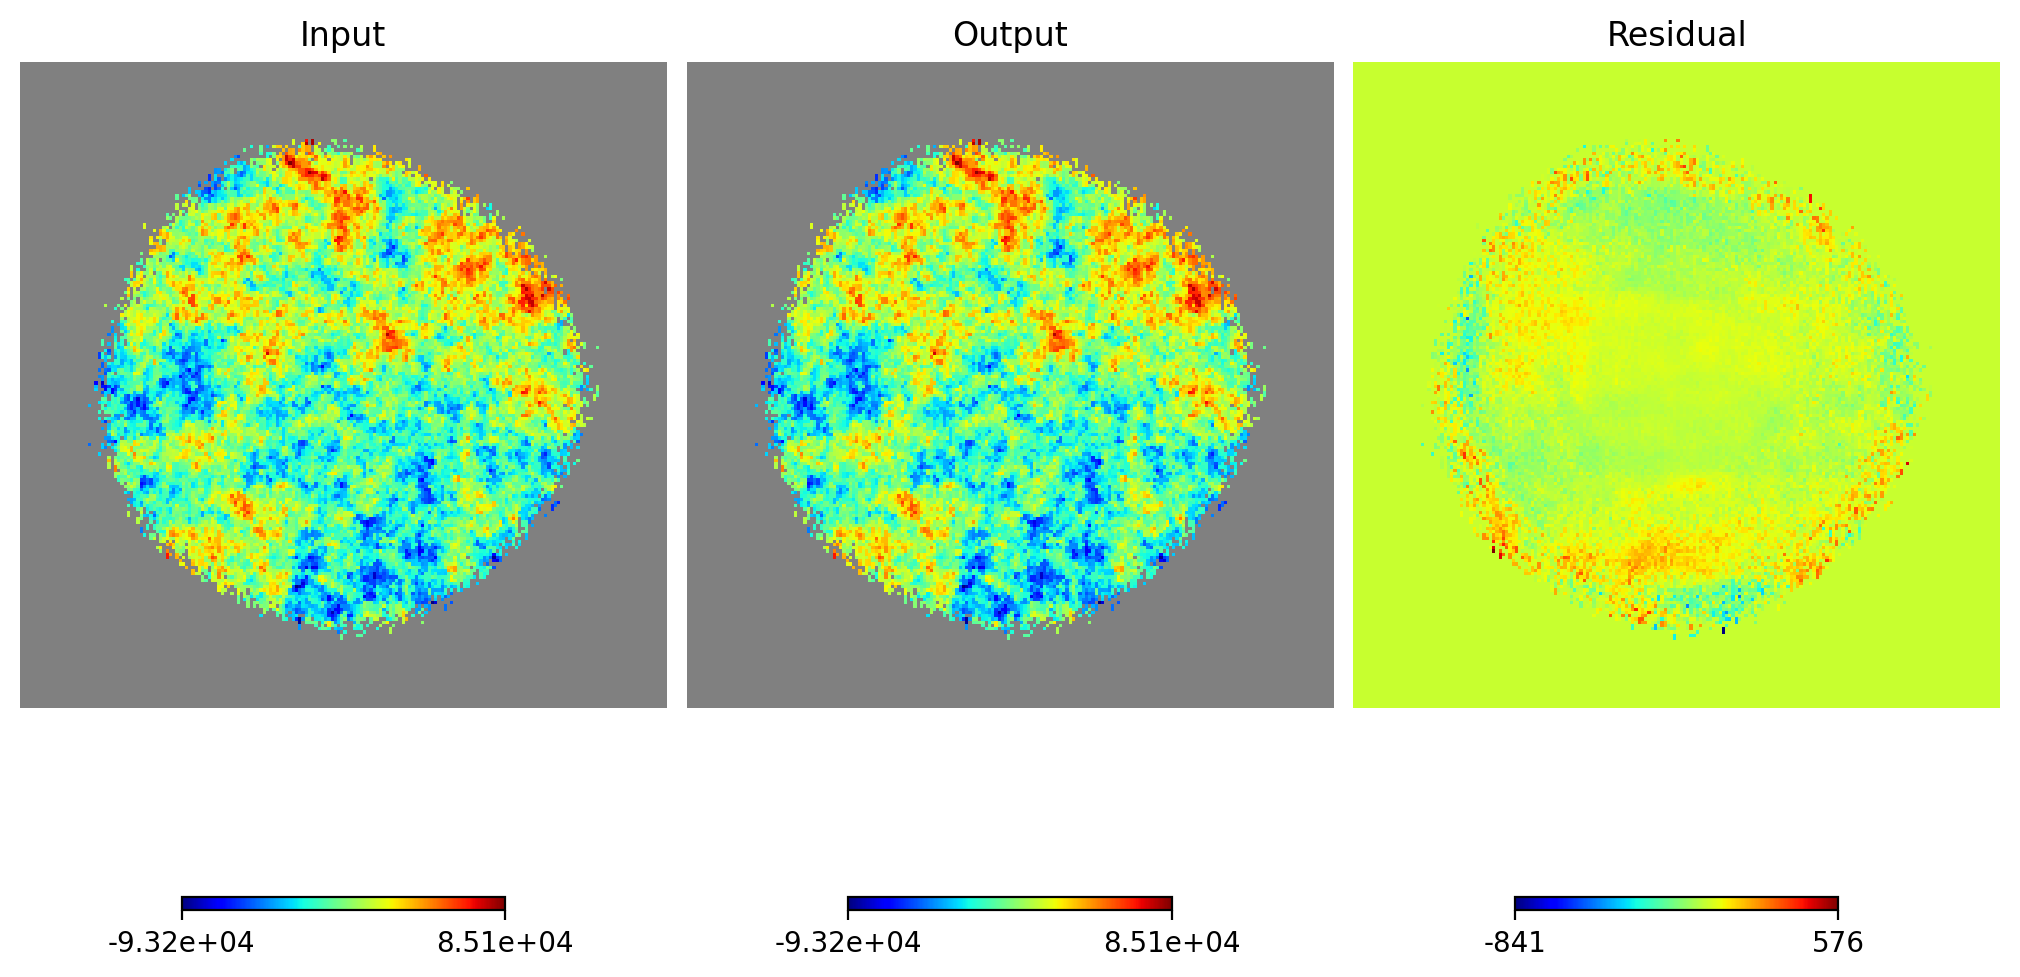

In [18]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k), title='Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+1), title='Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

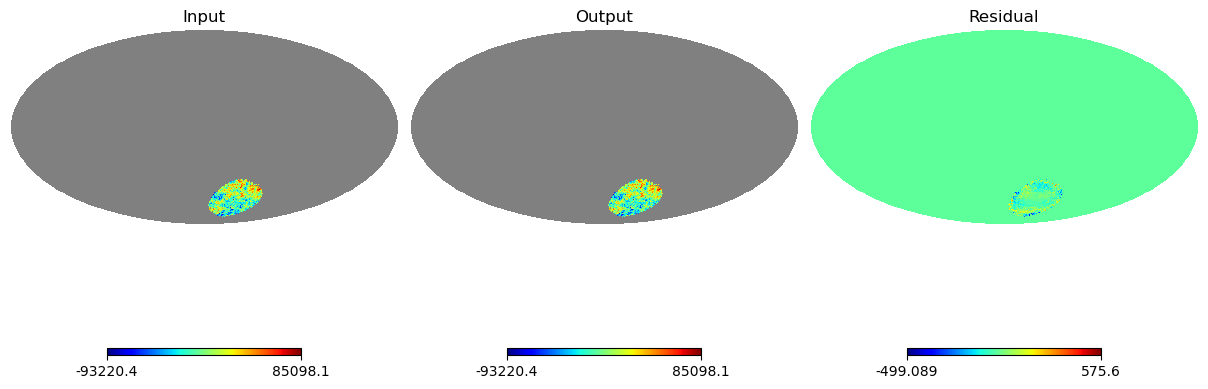

In [19]:
plt.figure(figsize=(12, 25))
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.mollview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k), title='Input', notext=True)
hp.mollview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k+1), title='Output', notext=True)
hp.mollview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

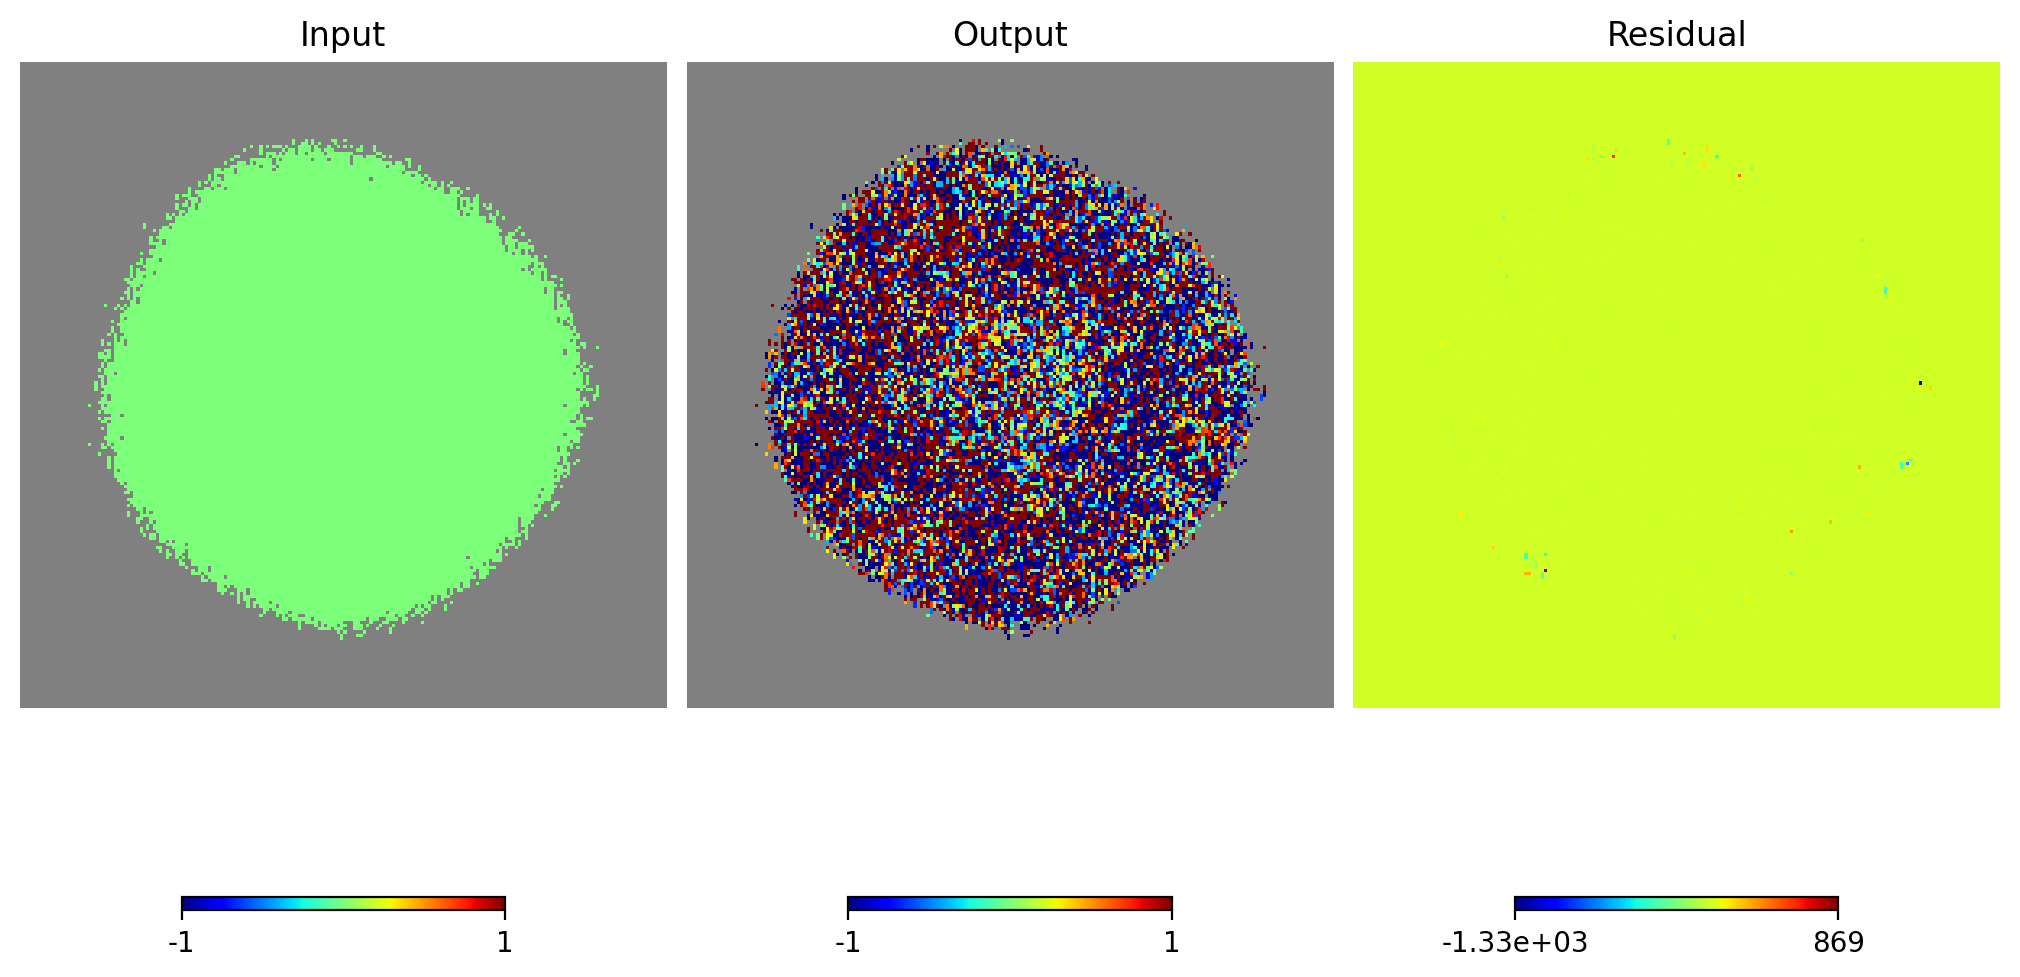

In [20]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 1
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k), title='Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+1), title='Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

In [21]:
npix = hp.nside2npix(128)
test = np.ones(npix)
cl = hp.anafast(test)

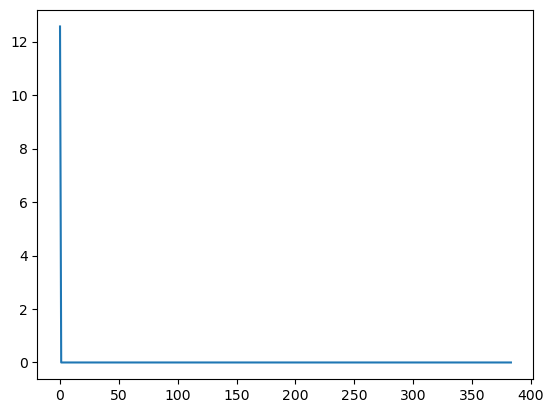

In [22]:
plt.plot(cl)

In [23]:
cl = np.zeros(100)
cl[10] = 1
cl[20] = 1
maps = hp.synfast(cl, 256)

In [24]:
maps.shape

(786432,)

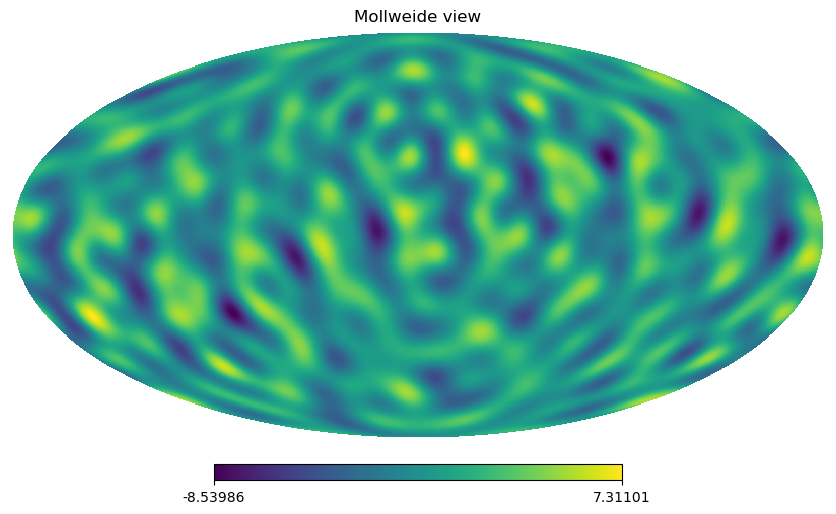

In [25]:
hp.mollview(maps)

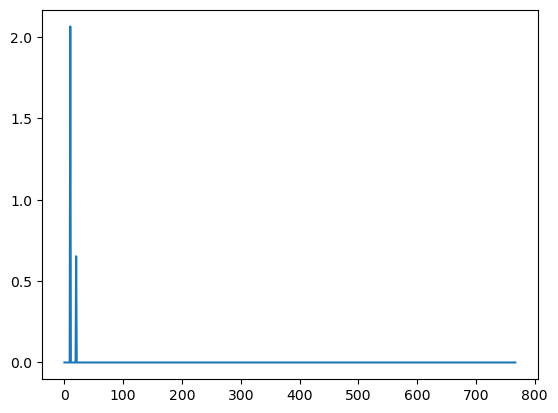

In [26]:
plt.plot(hp.anafast(maps))